# 1.0 Import of evaluation metrics

In [32]:
from pathlib import Path
from joblib import load
import pandas as pd
import re
from IPython.display import display
import pandas as pd
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [33]:
# relative to your notebooks/ cwd
folder = Path("../data/evaluation")

loaded = {}
for p in sorted(folder.glob("*.joblib")):
    try:
        obj = joblib.load(p)
    except Exception as e:
        print(f"Skipping {p.name}: load failed ({e})")
        continue

    # Ensure DataFrame
    if isinstance(obj, pd.DataFrame):
        df = obj
    else:
        try:
            df = pd.DataFrame(obj)
        except Exception:
            print(f"Skipping {p.name}: not a DataFrame and not convertible (type {type(obj).__name__})")
            continue

    # Variable name: force 'df_accuracy' for any accuracy file, else sanitized stem
    stem_lower = p.stem.lower()
    if "accuracy" in stem_lower:
        var = "df_accuracy"
    else:
        var = re.sub(r"\W|^(?=\d)", "_", p.stem)

    globals()[var] = df
    loaded[var] = df

# Show the dp_metrics_* tables (df_accuracy is now available for later use)
for name, obj in sorted(globals().items()):
    if isinstance(obj, pd.DataFrame) and name.startswith("dp_metrics_"):
        print(f"{name} (shape={obj.shape})")
        display(obj.head())

dp_metrics_baseline (shape=(43, 3))


,precision,recall,f1_score
decision_point,,,
DP 1,48.592352,48.110105,48.351095
DP 10,49.421102,49.402160,49.411631
DP 11,65.846912,65.751381,65.796057
DP 12,65.846912,65.751381,65.796057
DP 13,68.798730,68.724160,68.758425


dp_metrics_lstm_activity_only (shape=(43, 3))


,precision,recall,f1_score
decision_point,,,
DP 1,41.993526,64.804824,50.962513
DP 10,80.877275,85.039504,79.817528
DP 11,86.356167,85.544105,81.988583
DP 12,86.397740,85.528256,81.980009
DP 13,98.532244,98.521125,98.525695


dp_metrics_lstm_simple (shape=(43, 3))


,precision,recall,f1_score
decision_point,,,
DP 1,99.968232,99.968800,99.969200
DP 10,85.980480,87.838889,86.102789
DP 11,85.714114,86.559087,84.763817
DP 12,85.788171,86.714477,85.132486
DP 13,96.179715,96.210081,96.194949


# 1.1 Aggregation across Decision Points (Baseline, Activity, Simple, Advanced)

In [34]:
# collect and order models (Baseline first, then others)
models = []
for name, df in sorted(globals().items()):
    if isinstance(df, pd.DataFrame) and name.startswith("dp_metrics_"):
        label_raw = name[len("dp_metrics_"):]
        label = label_raw.replace("_", " ")
        label = re.sub(r'(?i)\blstm\b', 'LSTM', label)
        label = re.sub(r'(?i)\bbaseline\b', 'Baseline', label)
        models.append((label, df))

models.sort(key=lambda x: (0 if re.search(r'(?i)\bbaseline\b', x[0]) else 1, x[0].lower()))

print("\n=== Aggregated Across Decision Points ===")

# Precision
print("Precision")
for label, df in models:
    m, s = df["precision"].mean(), df["precision"].std()
    print(f"  Precision ({label}): {m:.3f} ± {s:.3f}")
print()

# Recall
print("Recall")
for label, df in models:
    m, s = df["recall"].mean(), df["recall"].std()
    print(f"  Recall ({label}):    {m:.3f} ± {s:.3f}")
print()

# F1-score
print("F1-score")
for label, df in models:
    m, s = df["f1_score"].mean(), df["f1_score"].std()
    print(f"  F1-score ({label}):  {m:.3f} ± {s:.3f}")


=== Aggregated Across Decision Points ===
Precision
  Precision (Baseline): 49.678 ± 18.679
  Precision (LSTM activity only): 84.401 ± 10.042
  Precision (LSTM simple): 89.070 ± 6.047

Recall
  Recall (Baseline):    49.533 ± 18.577
  Recall (LSTM activity only):    87.876 ± 6.295
  Recall (LSTM simple):    90.505 ± 5.353

F1-score
  F1-score (Baseline):  49.603 ± 18.628
  F1-score (LSTM activity only):  85.003 ± 8.582
  F1-score (LSTM simple):  88.948 ± 6.259


# 1.2. F1-Score per Decision Point

Plot saved to: /Users/m.ohmayer/Desktop/next_activity_prediction/results/per_dp_f1_all_models.png


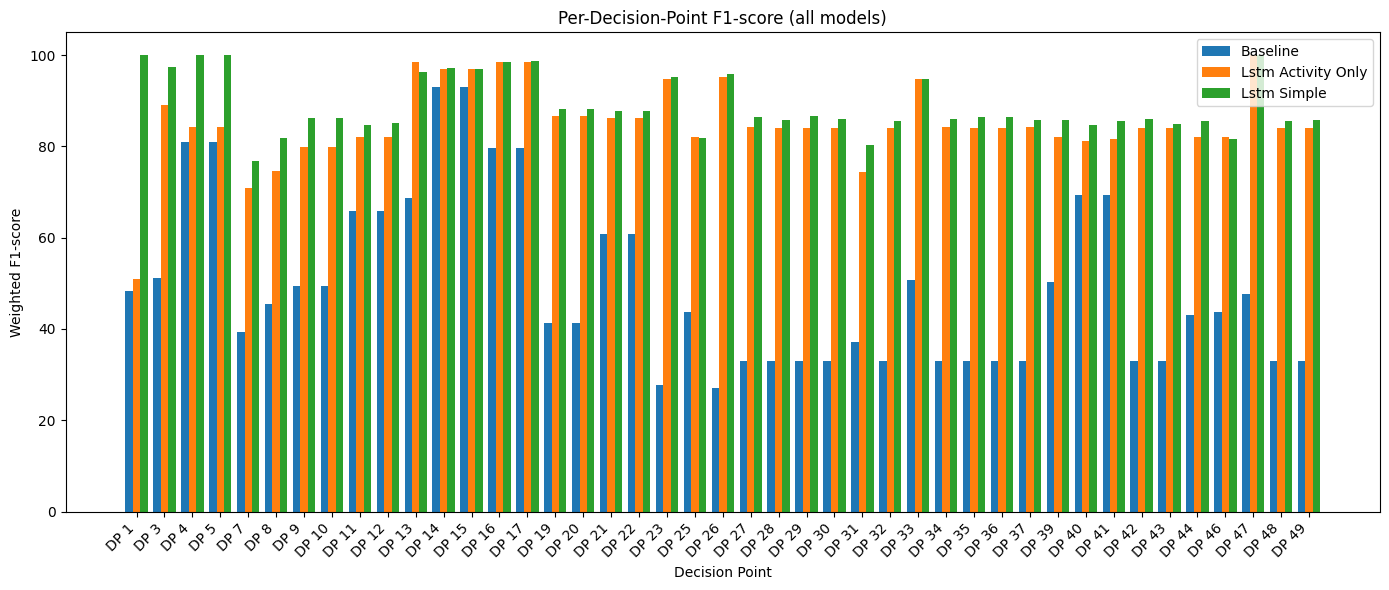

In [41]:
# Collect all loaded dp_metrics_* DataFrames and build a combined table of F1
models = {}
for name, df in sorted(globals().items()):
    if isinstance(df, pd.DataFrame) and name.startswith("dp_metrics_"):
        label = name.replace("dp_metrics_", "").replace("_", " ").title()  # e.g., "baseline" → "Baseline"
        models[label] = df

combined = None
for label, df in models.items():
    s = df["f1_score"].rename(label)
    combined = s.to_frame() if combined is None else combined.join(s, how="outer")

# Sort by DP number extracted from the index (e.g., "DP 12")
extract_num = lambda x: int(re.search(r"\d+", str(x)).group()) if re.search(r"\d+", str(x)) else float("inf")
combined["dp_number"] = combined.index.map(extract_num)
combined = combined.sort_values("dp_number").drop(columns=["dp_number"])

# Plot grouped bars with a different color per DataFrame
x = np.arange(len(combined))
n = combined.shape[1]
width = 0.8 / max(n, 1)

fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])

for i, col in enumerate(combined.columns):
    ax.bar(x - 0.4 + i*width + width/2, combined[col].values, width, label=col, color=colors[i % len(colors)])

ax.set_xlabel("Decision Point")
ax.set_ylabel("Weighted F1-score")
ax.set_title("Per-Decision-Point F1-score (all models)")
ax.set_xticks(x)
ax.set_xticklabels(combined.index, rotation=45, ha="right")
ax.legend()
fig.tight_layout()

# Save next to notebooks/ in ../results BEFORE show()
results_dir = (Path.cwd().parent / "results") if Path.cwd().name == "notebooks" else Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)
save_path = results_dir / "per_dp_f1_all_models.png"
fig.savefig(save_path, dpi=200, bbox_inches="tight")
print(f"Plot saved to: {save_path.resolve()}")

plt.show()

# 1.3. Performance vs. Number of Classes

Plot saved to: /Users/m.ohmayer/Desktop/next_activity_prediction/results/f1_vs_num_classes_all_models.png


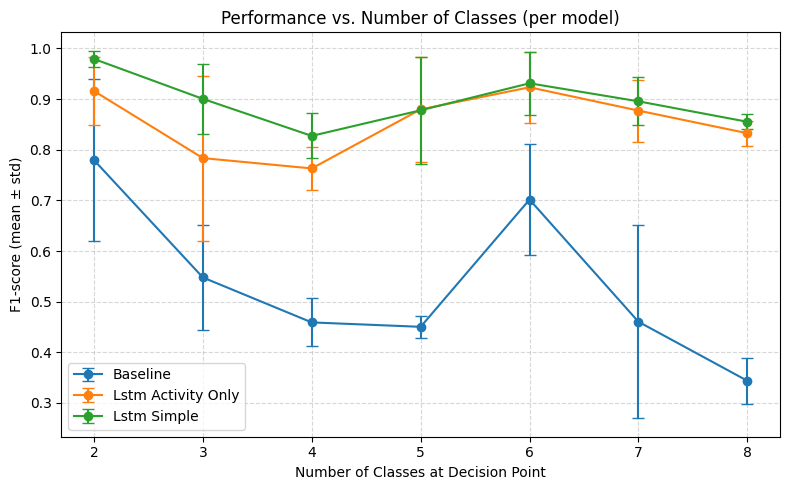

In [39]:
# 5) Plot error bars for each model (different color per model automatically)
fig, ax = plt.subplots(figsize=(8, 5))
for label, grouped in grouped_by_model.items():
    gi = grouped.reindex(x_vals)
    y = gi["f1_score"]["mean"].values
    yerr = gi["f1_score"]["std"].values
    ax.errorbar(x_vals, y, yerr=yerr, fmt='o-', capsize=4, label=label)

ax.set_xlabel("Number of Classes at Decision Point")
ax.set_ylabel("F1-score (mean ± std)")
ax.set_title("Performance vs. Number of Classes (per model)")
ax.set_xticks(x_vals)
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
fig.tight_layout()

# save figure next to notebooks/ in ../results
from pathlib import Path
results_dir = (Path.cwd().parent / "results") if Path.cwd().name == "notebooks" else Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

save_path = results_dir / "f1_vs_num_classes_all_models.png"
fig.savefig(save_path, dpi=200, bbox_inches="tight")  # <-- save BEFORE show
print(f"Plot saved to: {save_path.resolve()}")

plt.show()  # optional